## Realizado por J. A. Osorio

3.1 Para esta situación tomar el 20% como datos para realizar la validacion cruzada y el 80% para realizar el entrenamiento. Construir una curva del score en función del parametro gamma del clasificador que se esta empleando. ¿Cual presenta una mejor solucion al problema?

In [1]:
import sklearn 
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
from scipy import stats
from scipy import optimize
from scipy.stats import norm
from matplotlib import cm
from scipy.stats import multivariate_normal
from sklearn.model_selection import train_test_split
#Machinig learning models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve

In [2]:
def plot_learning_curve(
    estimator,
    title,
    X,
    y,
    axes=None,
    ylim=None,
    cv=None,
    n_jobs=None,
    train_sizes=np.linspace(0.1, 1.0, 5),
):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.

    title : str
        Title for the chart.

    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.

    axes : array-like of shape (3,), default=None
        Axes to use for plotting the curves.

    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like of shape (n_ticks,)
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        return_times=True,
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes[0].fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    axes[0].plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    axes[0].plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, "o-")
    axes[1].fill_between(
        train_sizes,
        fit_times_mean - fit_times_std,
        fit_times_mean + fit_times_std,
        alpha=0.1,
    )
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, "o-")
    axes[2].fill_between(
        fit_times_mean,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
    )
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

In [3]:
def make_meshgrid(x, y, h=0.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

In [61]:
def data( mu=[1,1], mu1=[-2,2], cov=[[1.0, 0.0], [0.0, 1.0]] , cov1= [[1.0, -0.5], [-0.5, 1.0]]   ):# Caso mas visible  
    rv = multivariate_normal(mu, cov)
    rv1 = multivariate_normal(mu1, cov1)
    return rv, rv1

def sample(N1= 1000, N2 = 100, r = 0.2):
    X_t = np.concatenate([rv.rvs(N1, random_state = r  ), rv1.rvs(N2,random_state = r)]) # Todos los datos en la misma distribución, 
    y   = np.concatenate([np.zeros(N1), np.ones(N2) ]  )
    return X_t, y


In [110]:
#variar la cantidad de datos
rv, rv1 = data( mu=[1.4,1.4], mu1=[1.4,-1.4], 
     cov=[[1.0, -0.8], [-0.8, 1.0]] , 
     cov1= [[1.0, 0.8], [0.8, 1.0]])
X_t, y = sample(N1 = 120, N2 = 100, r = 10)

#Arreglo para los scores
train_score = []
test_score = []

X_train, X_test, y_train, y_test = train_test_split(X_t, y, test_size = 0.2,  
                                                        random_state=1)
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=1)
#usamos escala logaritmica, ya que hay mayor variacion del score en la cross validation para gammas pequeños.
gamma_array = np.linspace(0.1, 10, 40)
#hacemos un loop sobre los valores gamma
for gamma_ in gamma_array:
    clf = SVC(gamma = gamma_)    
    #la funcion learning_curve nos da los scores usando cross-validation
    train_sizes, train_scores, test_scores = learning_curve(
        estimator=clf,
        X=X_t,
        y = y,
        cv=cv,
        n_jobs=1
    )
    #se deben promediar los datos, ya que se hace sobre varias corridas
    train_scores_mean = np.mean(train_scores, axis=1)[-1]#se toma el último dato que se corrió, para el cual training examples 
    test_scores_mean = np.mean(test_scores, axis=1)[-1]#maximo
    train_score.append(train_scores_mean)
    test_score.append(test_scores_mean)

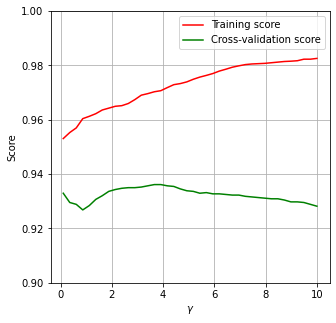

In [111]:
#graficamos
plt.figure(figsize=(5,5))
plt.plot(gamma_array, train_score, 'r-', label="Training score")
plt.plot(gamma_array, test_score, 'g-', label="Cross-validation score")
plt.legend(loc=0)
plt.xlabel(r"$\gamma$")
plt.ylabel("Score")
plt.ylim(0.9, 1)
plt.grid()

In [112]:
#encontramos el valor en el que el score de la cv es máximo
max_value = max(test_score)
max_index = test_score.index(max_value)
print("Gamma = %0.3f"%gamma_array[max_index], "|", "C-V score = %0.3f"%max_value)

Gamma = 3.654 | C-V score = 0.936


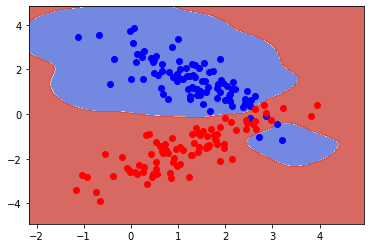

In [113]:
clf = SVC(gamma = gamma_array[max_index])
clf.fit(X_train, y_train)
fig, ax = plt.subplots()
X0, X1 = X_train[:, 0], X_train[:, 1]
xx, yy = make_meshgrid(X0, X1)
plot_contours(ax, clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
plt.plot(X_train[y_train==0][:,0],X_train[y_train==0][:,1],"bo", alpha=1)
plt.plot(X_train[y_train==1][:,0],X_train[y_train==1][:,1],"ro", alpha=1)

Notamos que para este valor de $\gamma = 0.37$, hay una buena clasificación de los datos.

3.2 Construir las curvas de aprendizaje estadístico para el modelo descrito, comprobar que la solución es similar a la esperada a través de sklearn.

In [114]:
#Metodo para generar k divisiones en forma de diccionario.
def get_K_divs(X_t, y, K, test_size_):
    divs = []
    for i in range(K):
        X_train, X_test, y_train, y_test = train_test_split(X_t, y, test_size = test_size_,  
                                                    random_state=None)
        divs.append({"X_train": X_train, "X_test": X_test, "y_train": y_train, "y_test": y_test})
    return divs
#Mi propia funcion de curva de aprendizaje
def learning_curve_JOHN(clf, X_t, y, K, test_size_):
    #obtenemos las divisiones
    divs = get_K_divs(X_t, y, K, test_size_)
    #print(divs)
    #para almanecenar la media y std
    training_score = []
    training_score_std = []
    test_score = []
    test_score_std = []
    test_score = []
    #hacemos los splits
    #como minimo deben haber dos pares, y como máximo, el tamaño de todo el arreglo
    for split in range(2, X_t.shape[0]):
        #valores para promediar
        sub_training_score = np.array([])
        sub_test_score = np.array([])
        for div in divs:             
            #hacemos una selección, el split representa el indice hasta donde
            X_train = div["X_train"][0:split]
            y_train = div["y_train"][0:split]
            
            X_test = div["X_test"]
            y_test = div["y_test"]
            #en algunos casos, hay valores de una sola clase, lanza error
            if(len(np.unique(y_train)) == 1):
                continue
          
            clf.fit(X_train, y_train)
            #calculamos los score
            sub_training_score = np.append(sub_training_score, clf.score(X_train, y_train))
            sub_test_score = np.append(sub_test_score, clf.score(X_test, y_test))
        training_score.append(np.mean(sub_training_score))
        training_score_std.append(np.std(sub_training_score))
        
        test_score.append(np.mean(sub_test_score))
        test_score_std.append(np.std(sub_test_score))
    train_size = np.arange(2, X_t.shape[0], 1)
    return train_size, np.array(training_score), np.array(training_score_std), np.array(test_score), np.array(test_score_std)
    #for train_index, test_index in cv.split(X_t):
     #   print(train_index, test_index)

In [115]:
#lo corremos para el punto anterior, con gamma maximo
clf = SVC(gamma = gamma_array[max_index])
train_size, training_score, training_score_std, test_score, test_score_std = learning_curve_JOHN(clf, X_t, y, 100, 0.2)

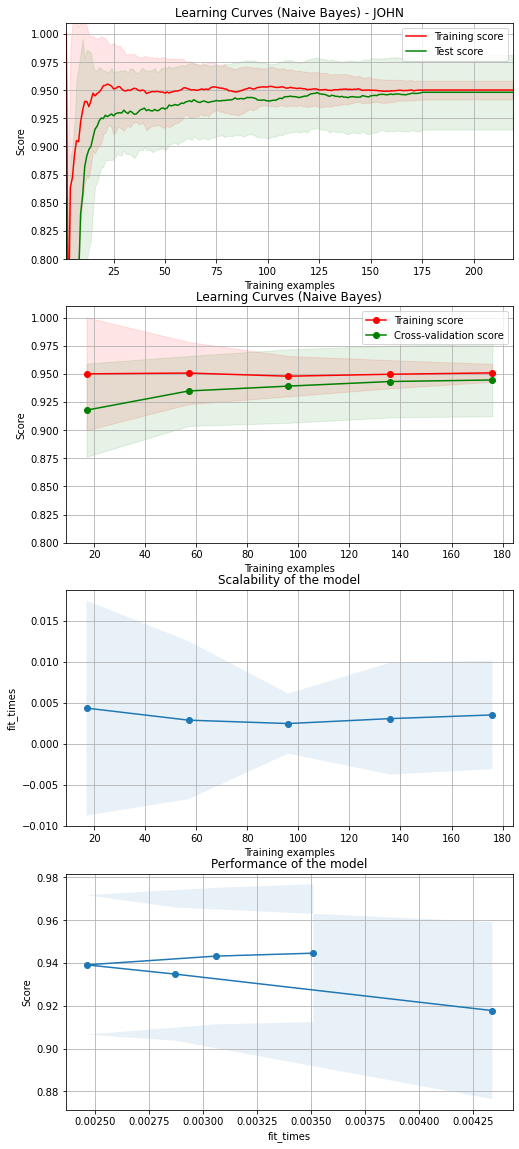

In [23]:
#graficacion
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
fig, axes = plt.subplots(4, 1, figsize=(8, 20))
#grafico las curvas obtenidas
axes[0].plot(train_size, training_score, 'r', label="Training score")
axes[0].fill_between(
        train_size,#sombra
        training_score - training_score_std,
        training_score + training_score_std,
        alpha=0.1,
        color="r",
    )
axes[0].plot(train_size, test_score,'g', label="Test score")
axes[0].fill_between(
        train_size,
        test_score - test_score_std,
        test_score + test_score_std,
        alpha=0.1,
        color="g",
    )
axes[0].set_title(u"Learning Curves (Naive Bayes) - JOHN")
axes[0].set_ylabel("Score")
axes[0].set_xlabel("Training examples")
axes[0].set_ylim(0.8, 1.01)
axes[0].set_xlim(train_size.min(), train_size.max())
axes[0].grid()
axes[0].legend(loc=0)
#utilizo el mismo conjunto de ejes que el anterior, y se juntan con las curvas de sklearn
title = "Learning Curves (Naive Bayes)"
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=None)
plot_learning_curve(clf, title, X_t, y, axes=axes[1:,], ylim=(0.8, 1.01), cv=cv, n_jobs=4)
plt.show()

Notamos que ambas curvas de aprendizaje tienen una forma y valores similares tanto para los datos de entrenamiento como de validación!!

3.3 Elegir, los párametros adecuados para los centros de medias y las matrices de covarianzas y mostrar Mostrar un ejemplo de Overfitting underfitting con el algoritmo generados construido por ustedes.  Analizar los resultados.


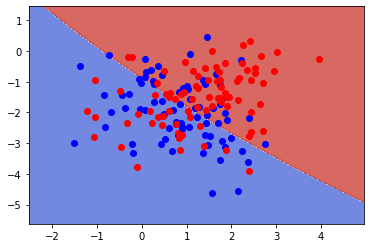

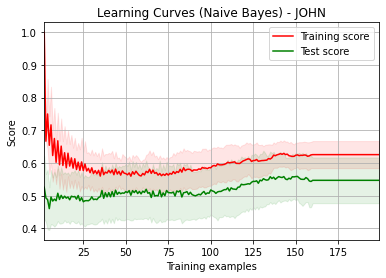

In [127]:
#Underfitting
rv, rv1 = data( mu=[1.0,-2.0], mu1=[1.4,-1.4], 
     cov=[[1.0, -0.3], [-0.3, 1.0]] , 
     cov1= [[1.0, 0.3], [0.3, 1.0]])
X_t, y = sample(N1 = 100, N2 = 100, r = 10)


X_train, X_test, y_train, y_test = train_test_split(X_t, y, test_size = 0.2,  
                                                    random_state=1)
clf = SVC(gamma = 0.01)
clf.fit(X_train, y_train)
fig, ax = plt.subplots()
X0, X1 = X_train[:, 0], X_train[:, 1]
xx, yy = make_meshgrid(X0, X1)
plot_contours(ax, clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
plt.plot(X_train[y_train==0][:,0],X_train[y_train==0][:,1],"bo", alpha=1)
plt.plot(X_train[y_train==1][:,0],X_train[y_train==1][:,1],"ro", alpha=1)
plt.show()

#clf = SVC(gamma = 20.0)
#clf.fit(X_t, y)
train_size, training_score, training_score_std, test_score, test_score_std = learning_curve_JOHN(clf, X_t, y, 50, 0.2)

#grafico las curvas obtenidas
plt.plot(train_size, training_score, 'r', label="Training score")
plt.fill_between(
        train_size,#sombra
        training_score - training_score_std,
        training_score + training_score_std,
        alpha=0.1,
        color="r",
    )
plt.plot(train_size, test_score,'g', label="Test score")
plt.fill_between(
        train_size,
        test_score - test_score_std,
        test_score + test_score_std,
        alpha=0.1,
        color="g",
    )
plt.title(u"Learning Curves (Naive Bayes) - JOHN")
plt.ylabel("Score")
plt.xlabel("Training examples")
#plt.ylim(0.8, 1.01)
plt.xlim(train_size.min(), train_size.max())
plt.grid()
plt.legend(loc=0)

Vemos un claro caso de underfitting. Hay un alto error y además se logra ver una pobre definición de las fronteras.

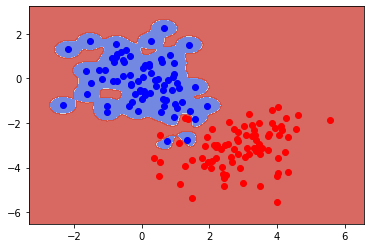

In [137]:
#Underfitting
rv, rv1 = data( mu=[0.2,-0.2], mu1=[3,-3], 
     cov=[[1.0, -0.3], [-0.3, 1.0]] , 
     cov1= [[1.0, 0.3], [0.3, 1.0]])
X_t, y = sample(N1 = 100, N2 = 100, r = 10)


X_train, X_test, y_train, y_test = train_test_split(X_t, y, test_size = 0.2,  
                                                    random_state=1)
clf = SVC(gamma = 20)
clf.fit(X_train, y_train)
fig, ax = plt.subplots()
X0, X1 = X_train[:, 0], X_train[:, 1]
xx, yy = make_meshgrid(X0, X1)
plot_contours(ax, clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
plt.plot(X_train[y_train==0][:,0],X_train[y_train==0][:,1],"bo", alpha=1)
plt.plot(X_train[y_train==1][:,0],X_train[y_train==1][:,1],"ro", alpha=1)
plt.show()


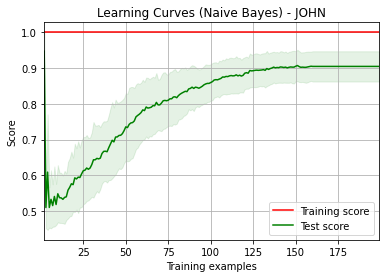

In [138]:

#clf = SVC(gamma = 20.0)
#clf.fit(X_t, y)
train_size, training_score, training_score_std, test_score, test_score_std = learning_curve_JOHN(clf, X_t, y, 50, 0.2)

#grafico las curvas obtenidas
plt.plot(train_size, training_score, 'r', label="Training score")
plt.fill_between(
        train_size,#sombra
        training_score - training_score_std,
        training_score + training_score_std,
        alpha=0.1,
        color="r",
    )
plt.plot(train_size, test_score,'g', label="Test score")
plt.fill_between(
        train_size,
        test_score - test_score_std,
        test_score + test_score_std,
        alpha=0.1,
        color="g",
    )
plt.title(u"Learning Curves (Naive Bayes) - JOHN")
plt.ylabel("Score")
plt.xlabel("Training examples")
#plt.ylim(0.8, 1.01)
plt.xlim(train_size.min(), train_size.max())
plt.grid()
plt.legend(loc=0)

Vemos un claro ejemplo de overfitting, los datos de entrenamiento están muy bien aprendidos, pero los datos de validación mantienen una separación con los de fit.